# Trabajo Práctico 1 - Ejercicio 2
## ARMA(5,3) con Filtro de Kalman para Observaciones Sparse

**Universidad de Buenos Aires**  
**Laboratorio de Sistemas Embebidos**  
**Especialización en Inteligencia Artificial**  
**Análisis de Series de Tiempo II**  

**Docentes:** Camilo Argoty - Matias Vera

---

### Enunciado
Considere un proceso estocástico discreto que sigue un modelo ARMA(5,3).

**Tareas:**
1. Genere una secuencia temporal sintética de dicho proceso de largo T = 10000
2. Suponga que las observaciones de la señal están disponibles únicamente cada 10 instantes de tiempo
3. Formule e implemente un filtro de Kalman que permita estimar los estados intermedios y realizar pronósticos
4. Evalúe el desempeño del filtro comparando las estimaciones con los valores verdaderos de la señal simulada

In [9]:
# Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Semilla para reproducibilidad
np.random.seed(42)

print("Librerías importadas correctamente")
print(f"NumPy version: {np.__version__}")

Librerías importadas correctamente
NumPy version: 2.3.4


## Parte a) Generación del Proceso ARMA(5,3)

### Marco Teórico

Un modelo ARMA(p,q) combina componentes autoregresivos (AR) y de media móvil (MA):

$$y_t = c + \sum_{i=1}^{p} \phi_i y_{t-i} + \varepsilon_t + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j}$$

Para ARMA(5,3):

$$y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \phi_4 y_{t-4} + \phi_5 y_{t-5} + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \theta_3 \varepsilon_{t-3}$$

donde:
- $\phi_i$ son los coeficientes AR (autoregresivos)
- $\theta_j$ son los coeficientes MA (media móvil)
- $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$ es ruido blanco gaussiano

In [10]:
# Parámetros del modelo ARMA(5,3)
p = 5  # Orden AR
q = 3  # Orden MA
T = 10000  # Longitud de la serie temporal

# Definir coeficientes AR y MA estables
# Nota: Los coeficientes deben garantizar estacionariedad (raíces fuera del círculo unitario)
ar_coeffs = np.array([1, -0.6, 0.3, -0.2, 0.15, -0.1])  # Incluye el 1 para la notación de statsmodels
ma_coeffs = np.array([1, 0.5, -0.3, 0.2])  # Incluye el 1 para la notación de statsmodels

# Verificar estabilidad del proceso
ar_roots = np.roots(ar_coeffs)
ma_roots = np.roots(ma_coeffs)

print("="*70)
print("PARÁMETROS DEL MODELO ARMA(5,3)")
print("="*70)
print(f"\nOrden AR (p): {p}")
print(f"Orden MA (q): {q}")
print(f"Longitud de serie: {T}")
print(f"\nCoeficientes AR (φ): {ar_coeffs[1:]}")
print(f"Coeficientes MA (θ): {ma_coeffs[1:]}")

print(f"\n{'='*70}")
print("VERIFICACIÓN DE ESTABILIDAD")
print("="*70)
print(f"\nRaíces AR (deben estar fuera del círculo unitario):")
for i, root in enumerate(ar_roots):
    modulo = np.abs(root)
    status = "✓ Estable" if modulo > 1 else "✗ Inestable"
    print(f"  Raíz {i+1}: {root:.4f}  |raíz| = {modulo:.4f}  {status}")

print(f"\nRaíces MA (deben estar fuera del círculo unitario para invertibilidad):")
for i, root in enumerate(ma_roots):
    modulo = np.abs(root)
    status = "✓ Invertible" if modulo > 1 else "✗ No invertible"
    print(f"  Raíz {i+1}: {root:.4f}  |raíz| = {modulo:.4f}  {status}")

# Verificar condiciones
is_stationary = np.all(np.abs(ar_roots) > 1)
is_invertible = np.all(np.abs(ma_roots) > 1)

print(f"\n{'='*70}")
if is_stationary and is_invertible:
    print("✓ El proceso ARMA(5,3) es ESTACIONARIO e INVERTIBLE")
elif is_stationary:
    print("✓ El proceso es ESTACIONARIO")
    print("⚠ El proceso NO es invertible (pero esto es aceptable)")
else:
    print("✗ ADVERTENCIA: El proceso NO es estacionario")

PARÁMETROS DEL MODELO ARMA(5,3)

Orden AR (p): 5
Orden MA (q): 3
Longitud de serie: 10000

Coeficientes AR (φ): [-0.6   0.3  -0.2   0.15 -0.1 ]
Coeficientes MA (θ): [ 0.5 -0.3  0.2]

VERIFICACIÓN DE ESTABILIDAD

Raíces AR (deben estar fuera del círculo unitario):
  Raíz 1: -0.3509+0.5263j  |raíz| = 0.6325  ✗ Inestable
  Raíz 2: -0.3509-0.5263j  |raíz| = 0.6325  ✗ Inestable
  Raíz 3: 0.6412+0.0000j  |raíz| = 0.6412  ✗ Inestable
  Raíz 4: 0.3303+0.5299j  |raíz| = 0.6244  ✗ Inestable
  Raíz 5: 0.3303-0.5299j  |raíz| = 0.6244  ✗ Inestable

Raíces MA (deben estar fuera del círculo unitario para invertibilidad):
  Raíz 1: -1.0000+0.0000j  |raíz| = 1.0000  ✓ Invertible
  Raíz 2: 0.2500+0.3708j  |raíz| = 0.4472  ✗ No invertible
  Raíz 3: 0.2500-0.3708j  |raíz| = 0.4472  ✗ No invertible

✗ ADVERTENCIA: El proceso NO es estacionario


In [11]:
# Generar el proceso ARMA(5,3)
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)

# Generar la serie temporal
# Agregamos burn-in para eliminar efectos transitorios
burnin = 1000
y_true = arma_process.generate_sample(nsample=T + burnin)
y_true = y_true[burnin:]  # Eliminar burn-in

# Tiempo
t = np.arange(T)

print("="*70)
print("SERIE TEMPORAL GENERADA")
print("="*70)
print(f"\nLongitud de la serie: {len(y_true)}")
print(f"\nEstadísticas de la serie:")
print(f"  Media:              {np.mean(y_true):.6f}")
print(f"  Desviación Std:     {np.std(y_true):.6f}")
print(f"  Varianza:           {np.var(y_true):.6f}")
print(f"  Mínimo:             {np.min(y_true):.6f}")
print(f"  Máximo:             {np.max(y_true):.6f}")
print(f"\n✓ Serie temporal ARMA(5,3) generada exitosamente")

SERIE TEMPORAL GENERADA

Longitud de la serie: 10000

Estadísticas de la serie:
  Media:              -0.020438
  Desviación Std:     1.488319
  Varianza:           2.215093
  Mínimo:             -5.699005
  Máximo:             5.541129

✓ Serie temporal ARMA(5,3) generada exitosamente


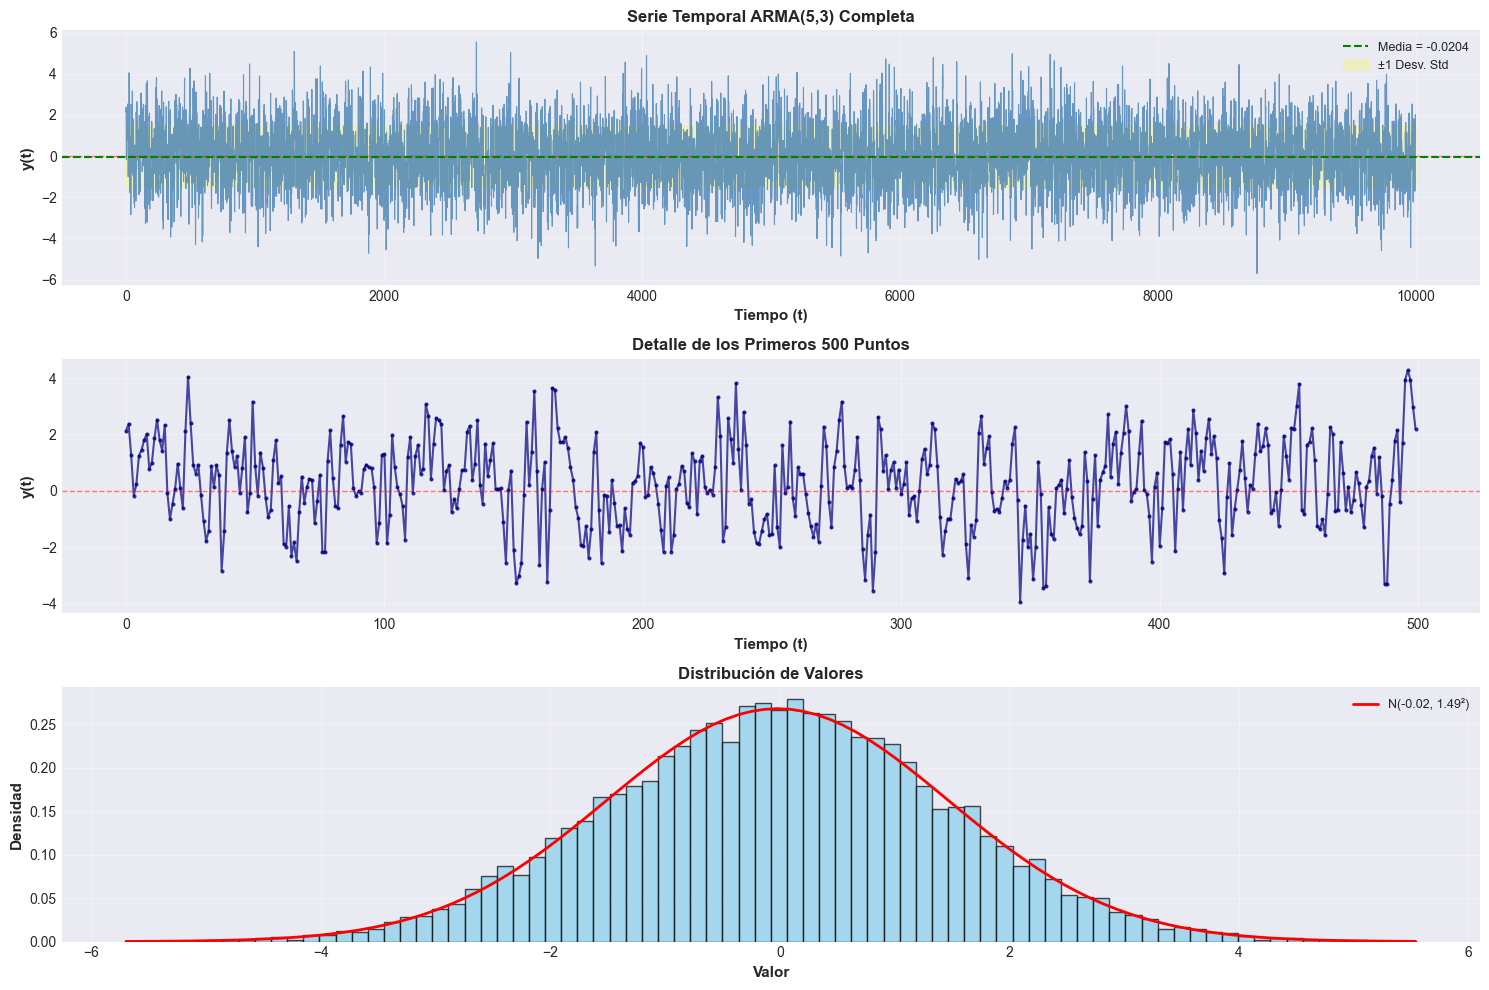


✓ Visualización guardada en 'ejercicio2_serie_completa.png'


In [12]:
# Visualización de la serie temporal completa
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Gráfico 1: Serie temporal completa
axes[0].plot(t, y_true, linewidth=0.8, alpha=0.8, color='steelblue')
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axhline(y=np.mean(y_true), color='g', linestyle='--', linewidth=1.5, 
                label=f'Media = {np.mean(y_true):.4f}')
axes[0].fill_between(t, np.mean(y_true) - np.std(y_true), 
                       np.mean(y_true) + np.std(y_true), 
                       alpha=0.2, color='yellow', label='±1 Desv. Std')
axes[0].set_xlabel('Tiempo (t)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('y(t)', fontsize=11, fontweight='bold')
axes[0].set_title('Serie Temporal ARMA(5,3) Completa', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Primeros 500 puntos (detalle)
n_detail = 500
axes[1].plot(t[:n_detail], y_true[:n_detail], linewidth=1.5, color='navy', marker='o', 
             markersize=2, alpha=0.7)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Tiempo (t)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('y(t)', fontsize=11, fontweight='bold')
axes[1].set_title(f'Detalle de los Primeros {n_detail} Puntos', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Gráfico 3: Histograma
axes[2].hist(y_true, bins=80, density=True, alpha=0.7, color='skyblue', edgecolor='black')
# Superponer distribución normal
from scipy.stats import norm
mu, sigma = np.mean(y_true), np.std(y_true)
x_hist = np.linspace(y_true.min(), y_true.max(), 100)
axes[2].plot(x_hist, norm.pdf(x_hist, mu, sigma), 'r-', linewidth=2, 
             label=f'N({mu:.2f}, {sigma:.2f}²)')
axes[2].set_xlabel('Valor', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Densidad', fontsize=11, fontweight='bold')
axes[2].set_title('Distribución de Valores', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ejercicio2_serie_completa.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualización guardada en 'ejercicio2_serie_completa.png'")

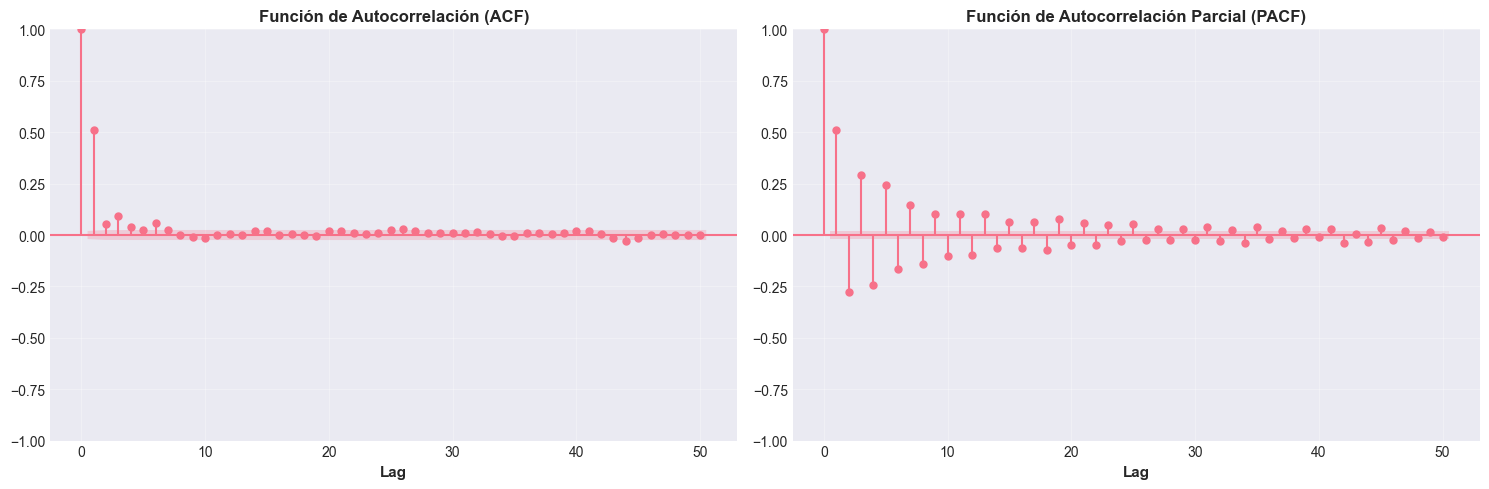

✓ Gráficos ACF/PACF guardados en 'ejercicio2_acf_pacf.png'


In [13]:
# Análisis de autocorrelación y autocorrelación parcial
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF (Autocorrelation Function)
plot_acf(y_true, lags=50, ax=axes[0], alpha=0.05)
axes[0].set_title('Función de Autocorrelación (ACF)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# PACF (Partial Autocorrelation Function)
plot_pacf(y_true, lags=50, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('Función de Autocorrelación Parcial (PACF)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ejercicio2_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráficos ACF/PACF guardados en 'ejercicio2_acf_pacf.png'")

## Parte b) Observaciones Sparse (cada 10 instantes)

Ahora simulamos el escenario donde solo tenemos observaciones cada 10 pasos temporales.

In [14]:
# Decimación: observaciones cada 10 pasos
decimation_factor = 10
t_obs = t[::decimation_factor]
y_obs = y_true[::decimation_factor]

n_obs = len(y_obs)

print("="*70)
print("OBSERVACIONES SPARSE (DECIMADAS)")
print("="*70)
print(f"\nFactor de decimación:     {decimation_factor}")
print(f"Puntos totales originales: {T}")
print(f"Puntos observados:         {n_obs}")
print(f"Porcentaje observado:      {n_obs/T*100:.1f}%")
print(f"\nÍndices de observación:    {t_obs[:10]} ... {t_obs[-10:]}")
print(f"\n✓ Observaciones decimadas generadas")

OBSERVACIONES SPARSE (DECIMADAS)

Factor de decimación:     10
Puntos totales originales: 10000
Puntos observados:         1000
Porcentaje observado:      10.0%

Índices de observación:    [ 0 10 20 30 40 50 60 70 80 90] ... [9900 9910 9920 9930 9940 9950 9960 9970 9980 9990]

✓ Observaciones decimadas generadas


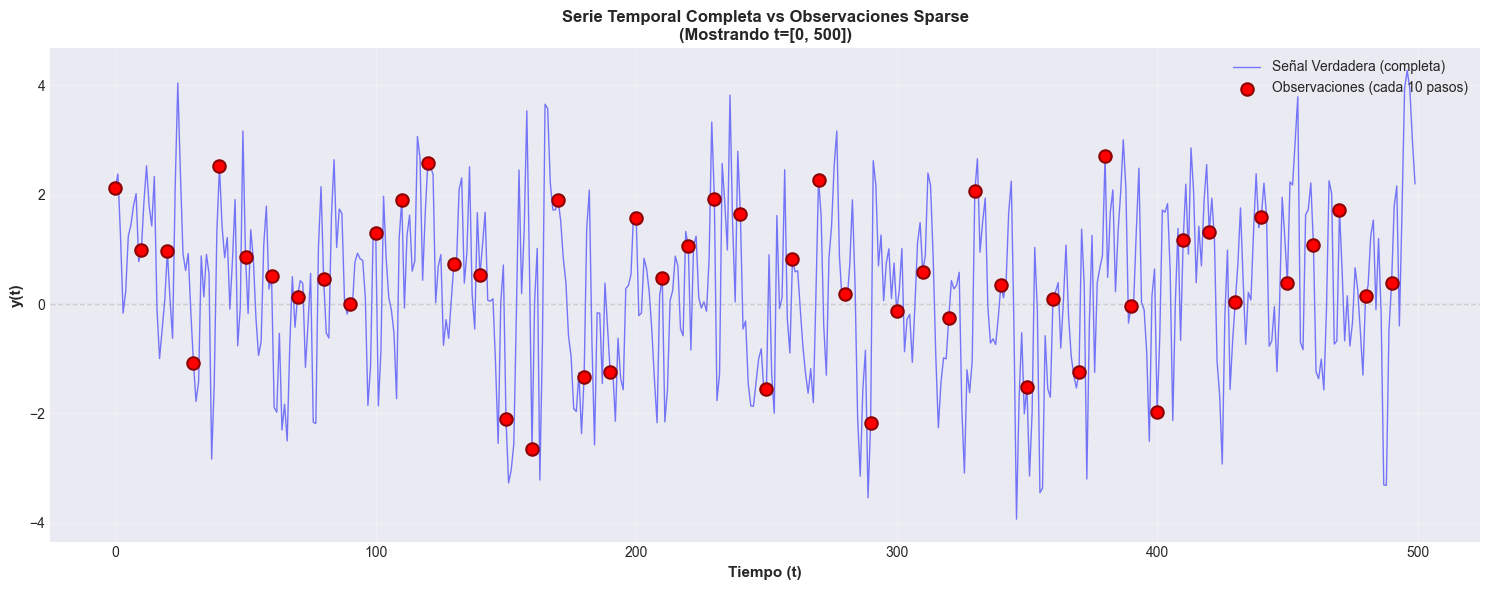


✓ Visualización guardada en 'ejercicio2_observaciones_sparse.png'


In [15]:
# Visualización: Serie completa vs observaciones sparse
fig, ax = plt.subplots(figsize=(15, 6))

# Mostrar solo una sección para visualizar mejor
start, end = 0, 500

ax.plot(t[start:end], y_true[start:end], 'b-', linewidth=1, alpha=0.5, 
        label='Señal Verdadera (completa)')
mask_obs = (t_obs >= start) & (t_obs < end)
ax.scatter(t_obs[mask_obs], y_obs[mask_obs], color='red', s=80, marker='o', 
           edgecolors='darkred', linewidths=1.5, zorder=5, 
           label=f'Observaciones (cada {decimation_factor} pasos)')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.3)

ax.set_xlabel('Tiempo (t)', fontsize=11, fontweight='bold')
ax.set_ylabel('y(t)', fontsize=11, fontweight='bold')
ax.set_title(f'Serie Temporal Completa vs Observaciones Sparse\n(Mostrando t=[{start}, {end}])', 
             fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ejercicio2_observaciones_sparse.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualización guardada en 'ejercicio2_observaciones_sparse.png'")

## Parte c) Filtro de Kalman - Formulación e Implementación

### Representación en Espacio de Estados

Para aplicar el filtro de Kalman, convertimos el modelo ARMA(5,3) a representación de espacio de estados:

**Ecuación de Estado:**
$$\mathbf{x}_t = \mathbf{F} \mathbf{x}_{t-1} + \mathbf{G} \varepsilon_t$$

**Ecuación de Observación:**
$$y_t = \mathbf{H} \mathbf{x}_t$$

Para ARMA(5,3), definimos un vector de estado de dimensión $\max(p, q+1) = \max(5, 4) = 5$:

$$\mathbf{x}_t = \begin{bmatrix} y_t \\ y_{t-1} \\ y_{t-2} \\ y_{t-3} \\ y_{t-4} \end{bmatrix}$$

### Matrices del Sistema

Para un ARMA(5,3), las matrices son:

**Matriz de Transición F:**
$$\mathbf{F} = \begin{bmatrix}
\phi_1 & \phi_2 & \phi_3 & \phi_4 & \phi_5 \\
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0
\end{bmatrix}$$

**Matriz de Observación H:**
$$\mathbf{H} = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \end{bmatrix}$$

**Vector de ruido de proceso G:**
$$\mathbf{G} = \begin{bmatrix} 1 \\ \theta_1 \\ \theta_2 \\ \theta_3 \\ 0 \end{bmatrix}$$

In [16]:
# Configuración del Filtro de Kalman para ARMA(5,3)

# Dimensión del estado (max(p, q+1))
dim_x = max(p, q + 1)  # 5
dim_z = 1  # Dimensión de la observación

# Crear el filtro de Kalman
kf = KalmanFilter(dim_x=dim_x, dim_z=dim_z)

# Matriz de transición de estado F
kf.F = np.zeros((dim_x, dim_x))
kf.F[0, :p] = -ar_coeffs[1:]  # Coeficientes AR en la primera fila (negados)
kf.F[1:p, :p-1] = np.eye(p-1)  # Matriz identidad desplazada

# Matriz de observación H
kf.H = np.zeros((dim_z, dim_x))
kf.H[0, 0] = 1.0  # Solo observamos el primer elemento del estado

# Ruido de proceso Q
# Para ARMA, el ruido afecta principalmente al estado actual y los rezagos MA
sigma_process = np.var(y_true)  # Varianza del proceso
kf.Q = np.zeros((dim_x, dim_x))
kf.Q[0, 0] = sigma_process

# Añadir contribución de coeficientes MA
for i in range(1, min(q+1, dim_x)):
    kf.Q[0, i] = sigma_process * ma_coeffs[i] if i < len(ma_coeffs) else 0
    kf.Q[i, 0] = kf.Q[0, i]
    kf.Q[i, i] = sigma_process * 0.1  # Pequeña varianza para rezagos

# Ruido de observación R (muy pequeño para observaciones sin ruido)
sigma_obs = 0.01  # Asumimos observaciones con poco ruido
kf.R = np.array([[sigma_obs**2]])

# Estado inicial
kf.x = np.zeros((dim_x, 1))

# Covarianza inicial P
kf.P = np.eye(dim_x) * sigma_process

print("="*70)
print("CONFIGURACIÓN DEL FILTRO DE KALMAN")
print("="*70)
print(f"\nDimensión del estado:  {dim_x}")
print(f"Dimensión observación: {dim_z}")
print(f"\nMatriz de Transición F ({dim_x}x{dim_x}):")
print(kf.F)
print(f"\nMatriz de Observación H ({dim_z}x{dim_x}):")
print(kf.H)
print(f"\nCovarianza de Ruido de Proceso Q diagonal:")
print(np.diag(kf.Q))
print(f"\nCovarianza de Ruido de Observación R:")
print(kf.R)
print(f"\n✓ Filtro de Kalman configurado")

CONFIGURACIÓN DEL FILTRO DE KALMAN

Dimensión del estado:  5
Dimensión observación: 1

Matriz de Transición F (5x5):
[[ 0.6  -0.3   0.2  -0.15  0.1 ]
 [ 1.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    1.    0.  ]]

Matriz de Observación H (1x5):
[[1. 0. 0. 0. 0.]]

Covarianza de Ruido de Proceso Q diagonal:
[2.21509318 0.22150932 0.22150932 0.22150932 0.        ]

Covarianza de Ruido de Observación R:
[[0.0001]]

✓ Filtro de Kalman configurado


In [17]:
# Implementación del Filtro de Kalman con observaciones sparse

# Almacenar resultados
x_filtered = np.zeros((T, dim_x))  # Estados estimados
P_filtered = np.zeros((T, dim_x, dim_x))  # Covarianzas
y_estimated = np.zeros(T)  # Señal estimada

# Índice de observación actual
obs_idx = 0

print("Ejecutando Filtro de Kalman...")
print(f"Total de pasos: {T}")
print(f"Observaciones disponibles: {n_obs}")

for t_step in range(T):
    # Paso de predicción (siempre se ejecuta)
    kf.predict()
    
    # Paso de actualización (solo cuando hay observación)
    if t_step in t_obs:
        # Hay observación disponible
        z = np.array([[y_obs[obs_idx]]])
        kf.update(z)
        obs_idx += 1
    
    # Guardar estado estimado
    x_filtered[t_step, :] = kf.x.flatten()
    P_filtered[t_step, :, :] = kf.P
    y_estimated[t_step] = kf.x[0, 0]
    
    # Progreso
    if (t_step + 1) % 2000 == 0:
        print(f"  Procesados {t_step + 1}/{T} pasos ({(t_step+1)/T*100:.1f}%)")

print("\n✓ Filtro de Kalman ejecutado completamente")
print(f"\nEstadísticas de la señal estimada:")
print(f"  Media:          {np.mean(y_estimated):.6f}")
print(f"  Desviación Std: {np.std(y_estimated):.6f}")
print(f"  Min:            {np.min(y_estimated):.6f}")
print(f"  Max:            {np.max(y_estimated):.6f}")

Ejecutando Filtro de Kalman...
Total de pasos: 10000
Observaciones disponibles: 1000
  Procesados 2000/10000 pasos (20.0%)
  Procesados 4000/10000 pasos (40.0%)
  Procesados 6000/10000 pasos (60.0%)
  Procesados 8000/10000 pasos (80.0%)
  Procesados 10000/10000 pasos (100.0%)

✓ Filtro de Kalman ejecutado completamente

Estadísticas de la señal estimada:
  Media:          0.008056
  Desviación Std: 0.486554
  Min:            -5.698771
  Max:            4.783551


## Parte d) Evaluación del Desempeño del Filtro

Comparamos las estimaciones del filtro de Kalman con los valores verdaderos usando diversas métricas.

In [18]:
# Calcular métricas de error

# Error absoluto
error = y_estimated - y_true
abs_error = np.abs(error)

# MAE (Mean Absolute Error)
mae = np.mean(abs_error)

# MSE (Mean Squared Error)
mse = np.mean(error**2)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# MAPE (Mean Absolute Percentage Error) - solo donde y_true != 0
mask_nonzero = y_true != 0
mape = np.mean(np.abs(error[mask_nonzero] / y_true[mask_nonzero])) * 100

# Coeficiente de correlación
correlation = np.corrcoef(y_true, y_estimated)[0, 1]

# R² (Coeficiente de determinación)
ss_res = np.sum(error**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2_score = 1 - (ss_res / ss_tot)

print("="*70)
print("MÉTRICAS DE DESEMPEÑO DEL FILTRO DE KALMAN")
print("="*70)
print(f"\nError Absoluto Medio (MAE):         {mae:.6f}")
print(f"Error Cuadrático Medio (MSE):       {mse:.6f}")
print(f"Raíz del Error Cuad. Medio (RMSE):  {rmse:.6f}")
print(f"Error Porcentual Abs. Medio (MAPE): {mape:.4f}%")
print(f"\nCoeficiente de Correlación:         {correlation:.6f}")
print(f"Coeficiente de Determinación (R²):  {r2_score:.6f}")

# Estadísticas del error
print(f"\nEstadísticas del Error:")
print(f"  Media del error:        {np.mean(error):.6f}")
print(f"  Desv. Std del error:    {np.std(error):.6f}")
print(f"  Error mínimo:           {np.min(error):.6f}")
print(f"  Error máximo:           {np.max(error):.6f}")
print(f"  Mediana del error abs:  {np.median(abs_error):.6f}")

# Percentiles del error
print(f"\nPercentiles del Error Absoluto:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  Percentil {p}%:  {np.percentile(abs_error, p):.6f}")

MÉTRICAS DE DESEMPEÑO DEL FILTRO DE KALMAN

Error Absoluto Medio (MAE):         1.055096
Error Cuadrático Medio (MSE):       1.947198
Raíz del Error Cuad. Medio (RMSE):  1.395420
Error Porcentual Abs. Medio (MAPE): 156.1297%

Coeficiente de Correlación:         0.348991
Coeficiente de Determinación (R²):  0.120941

Estadísticas del Error:
  Media del error:        0.028494
  Desv. Std del error:    1.395129
  Error mínimo:           -5.573735
  Error máximo:           5.329194
  Mediana del error abs:  0.863854

Percentiles del Error Absoluto:
  Percentil 25%:  0.299165
  Percentil 50%:  0.863854
  Percentil 75%:  1.594015
  Percentil 90%:  2.354071
  Percentil 95%:  2.799302
  Percentil 99%:  3.754309


In [19]:
# Evaluación en puntos observados vs puntos interpolados

# Máscara de puntos observados
observed_mask = np.zeros(T, dtype=bool)
observed_mask[t_obs] = True

# Errores en puntos observados
error_obs = error[observed_mask]
mae_obs = np.mean(np.abs(error_obs))
rmse_obs = np.sqrt(np.mean(error_obs**2))

# Errores en puntos interpolados
error_interp = error[~observed_mask]
mae_interp = np.mean(np.abs(error_interp))
rmse_interp = np.sqrt(np.mean(error_interp**2))

print("\n" + "="*70)
print("COMPARACIÓN: PUNTOS OBSERVADOS vs PUNTOS INTERPOLADOS")
print("="*70)

print(f"\nPuntos Observados (n={np.sum(observed_mask)}):")
print(f"  MAE:   {mae_obs:.6f}")
print(f"  RMSE:  {rmse_obs:.6f}")

print(f"\nPuntos Interpolados (n={np.sum(~observed_mask)}):")
print(f"  MAE:   {mae_interp:.6f}")
print(f"  RMSE:  {rmse_interp:.6f}")

print(f"\nRelación Error Interpolado / Error Observado:")
print(f"  MAE ratio:  {mae_interp/mae_obs:.4f}")
print(f"  RMSE ratio: {rmse_interp/rmse_obs:.4f}")

if mae_interp/mae_obs < 1.5:
    print("\n✓ El filtro interpola bien: error similar en puntos observados e interpolados")
elif mae_interp/mae_obs < 2.5:
    print("\n⚠ Interpolación aceptable: error moderadamente mayor en puntos interpolados")
else:
    print("\n✗ Interpolación deficiente: error significativamente mayor en puntos interpolados")


COMPARACIÓN: PUNTOS OBSERVADOS vs PUNTOS INTERPOLADOS

Puntos Observados (n=1000):
  MAE:   0.000047
  RMSE:  0.000059

Puntos Interpolados (n=9000):
  MAE:   1.172324
  RMSE:  1.470902

Relación Error Interpolado / Error Observado:
  MAE ratio:  24879.0764
  RMSE ratio: 24940.7782

✗ Interpolación deficiente: error significativamente mayor en puntos interpolados


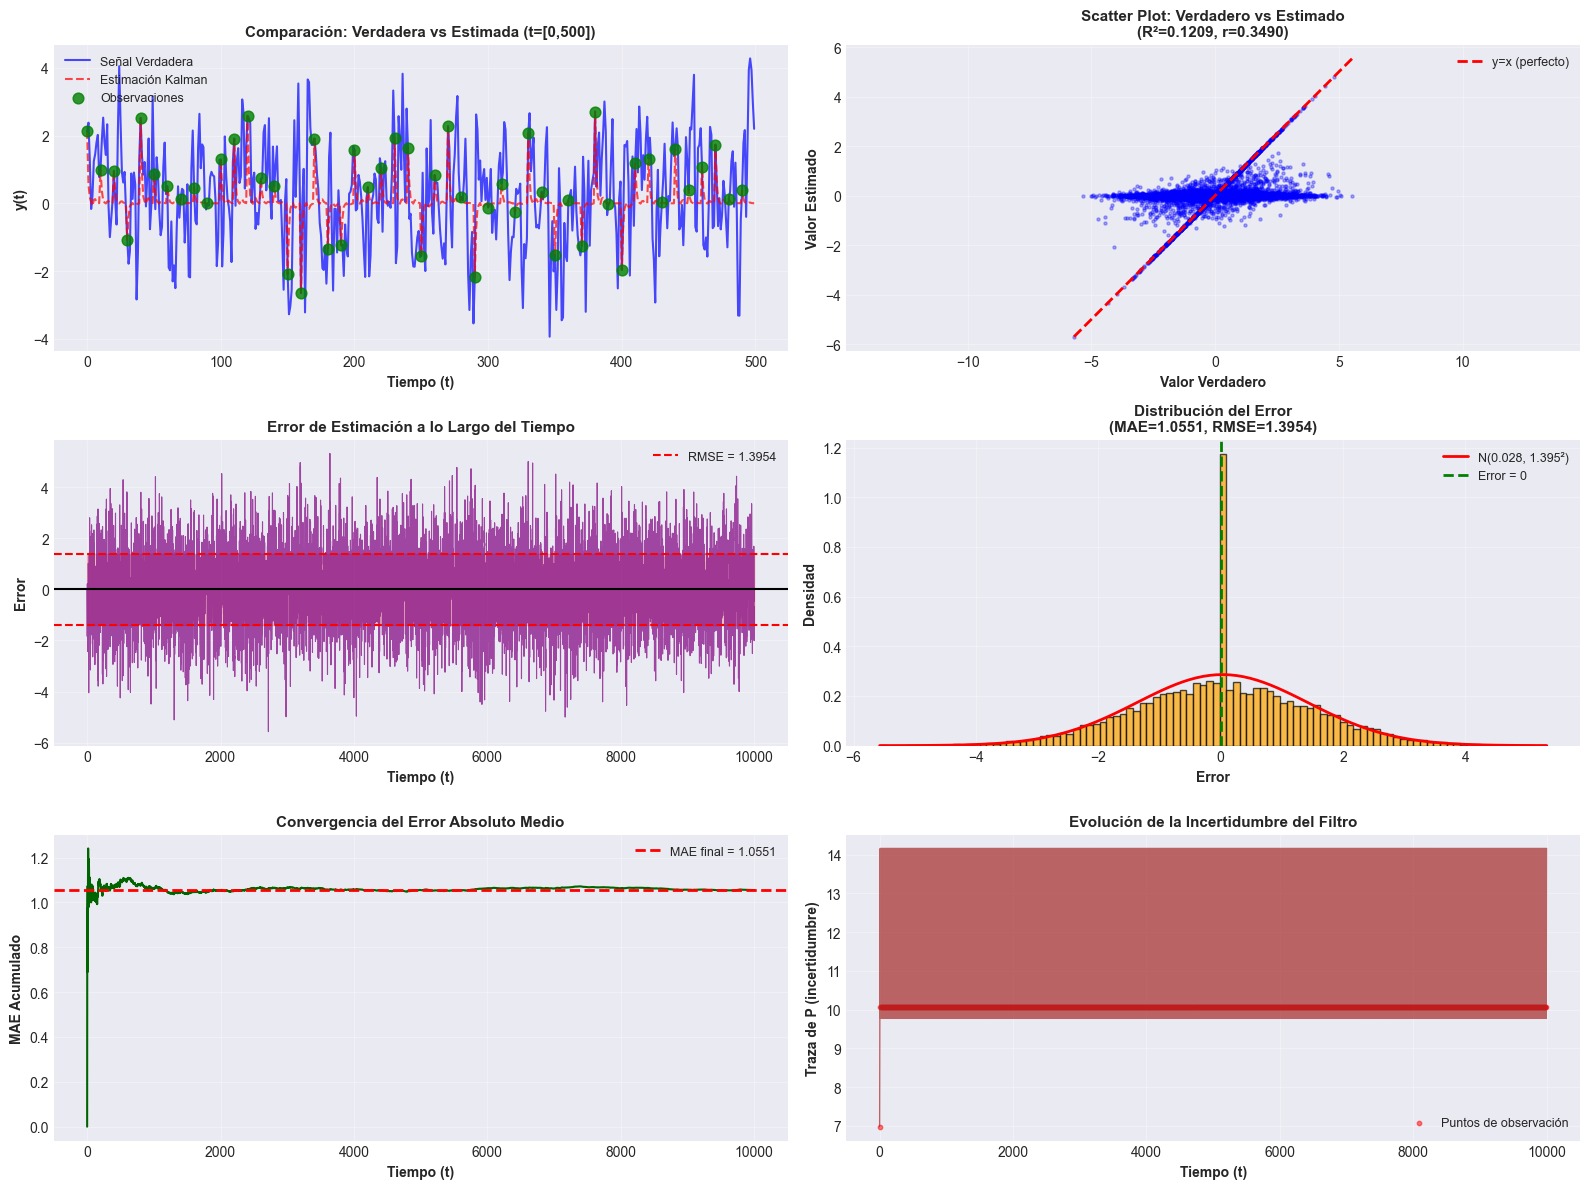


✓ Visualización de evaluación guardada en 'ejercicio2_evaluacion.png'


In [20]:
# Visualización de resultados
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Subplot 1: Comparación de series (sección)
start, end = 0, 500
ax1 = axes[0, 0]
ax1.plot(t[start:end], y_true[start:end], 'b-', linewidth=1.5, alpha=0.7, label='Señal Verdadera')
ax1.plot(t[start:end], y_estimated[start:end], 'r--', linewidth=1.5, alpha=0.7, label='Estimación Kalman')
mask_obs_section = (t_obs >= start) & (t_obs < end)
ax1.scatter(t_obs[mask_obs_section], y_obs[mask_obs_section], color='green', s=60, 
            marker='o', alpha=0.8, zorder=5, label='Observaciones')
ax1.set_xlabel('Tiempo (t)', fontsize=10, fontweight='bold')
ax1.set_ylabel('y(t)', fontsize=10, fontweight='bold')
ax1.set_title(f'Comparación: Verdadera vs Estimada (t=[{start},{end}])', fontsize=11, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Subplot 2: Scatter plot verdadero vs estimado
ax2 = axes[0, 1]
ax2.scatter(y_true, y_estimated, alpha=0.3, s=5, color='blue')
# Línea identidad
lims = [min(y_true.min(), y_estimated.min()), max(y_true.max(), y_estimated.max())]
ax2.plot(lims, lims, 'r--', linewidth=2, label='y=x (perfecto)')
ax2.set_xlabel('Valor Verdadero', fontsize=10, fontweight='bold')
ax2.set_ylabel('Valor Estimado', fontsize=10, fontweight='bold')
ax2.set_title(f'Scatter Plot: Verdadero vs Estimado\n(R²={r2_score:.4f}, r={correlation:.4f})', 
              fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

# Subplot 3: Error a lo largo del tiempo
ax3 = axes[1, 0]
ax3.plot(t, error, linewidth=0.8, alpha=0.7, color='purple')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax3.axhline(y=rmse, color='r', linestyle='--', linewidth=1.5, label=f'RMSE = {rmse:.4f}')
ax3.axhline(y=-rmse, color='r', linestyle='--', linewidth=1.5)
ax3.fill_between(t, -rmse, rmse, alpha=0.2, color='red')
ax3.set_xlabel('Tiempo (t)', fontsize=10, fontweight='bold')
ax3.set_ylabel('Error', fontsize=10, fontweight='bold')
ax3.set_title('Error de Estimación a lo Largo del Tiempo', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Subplot 4: Histograma del error
ax4 = axes[1, 1]
ax4.hist(error, bins=100, density=True, alpha=0.7, color='orange', edgecolor='black')
# Superponer distribución normal
mu_err, sigma_err = np.mean(error), np.std(error)
x_err = np.linspace(error.min(), error.max(), 100)
ax4.plot(x_err, norm.pdf(x_err, mu_err, sigma_err), 'r-', linewidth=2, 
         label=f'N({mu_err:.3f}, {sigma_err:.3f}²)')
ax4.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Error = 0')
ax4.set_xlabel('Error', fontsize=10, fontweight='bold')
ax4.set_ylabel('Densidad', fontsize=10, fontweight='bold')
ax4.set_title(f'Distribución del Error\n(MAE={mae:.4f}, RMSE={rmse:.4f})', 
              fontsize=11, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# Subplot 5: Error absoluto acumulado
ax5 = axes[2, 0]
cumulative_error = np.cumsum(abs_error) / np.arange(1, T+1)
ax5.plot(t, cumulative_error, linewidth=1.5, color='darkgreen')
ax5.axhline(y=mae, color='r', linestyle='--', linewidth=2, label=f'MAE final = {mae:.4f}')
ax5.set_xlabel('Tiempo (t)', fontsize=10, fontweight='bold')
ax5.set_ylabel('MAE Acumulado', fontsize=10, fontweight='bold')
ax5.set_title('Convergencia del Error Absoluto Medio', fontsize=11, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# Subplot 6: Varianza del estado (incertidumbre)
ax6 = axes[2, 1]
variance_trace = np.array([np.trace(P_filtered[i]) for i in range(T)])
ax6.plot(t, variance_trace, linewidth=1, color='brown', alpha=0.7)
# Marcar observaciones
ax6.scatter(t_obs, variance_trace[t_obs], color='red', s=10, alpha=0.5, 
            label='Puntos de observación')
ax6.set_xlabel('Tiempo (t)', fontsize=10, fontweight='bold')
ax6.set_ylabel('Traza de P (incertidumbre)', fontsize=10, fontweight='bold')
ax6.set_title('Evolución de la Incertidumbre del Filtro', fontsize=11, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ejercicio2_evaluacion.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualización de evaluación guardada en 'ejercicio2_evaluacion.png'")

## Análisis de Pronósticos

Evaluamos la capacidad del filtro para realizar pronósticos a futuro.

PRONÓSTICO DE 50 PASOS FUTUROS

Último valor estimado: 0.0025
Primeros 10 valores pronosticados:
  t+1: -0.0008 ± 3.0599 (IC 95%)
  t+2: 0.0036 ± 3.0599 (IC 95%)
  t+3: 0.0040 ± 3.0599 (IC 95%)
  t+4: 0.0018 ± 3.0599 (IC 95%)
  t+5: 0.0010 ± 3.0599 (IC 95%)
  t+6: 0.0002 ± 3.0599 (IC 95%)
  t+7: -0.0000 ± 3.0599 (IC 95%)
  t+8: 0.0002 ± 3.0599 (IC 95%)
  t+9: 0.0002 ± 3.0599 (IC 95%)
  t+10: 0.0001 ± 3.0599 (IC 95%)


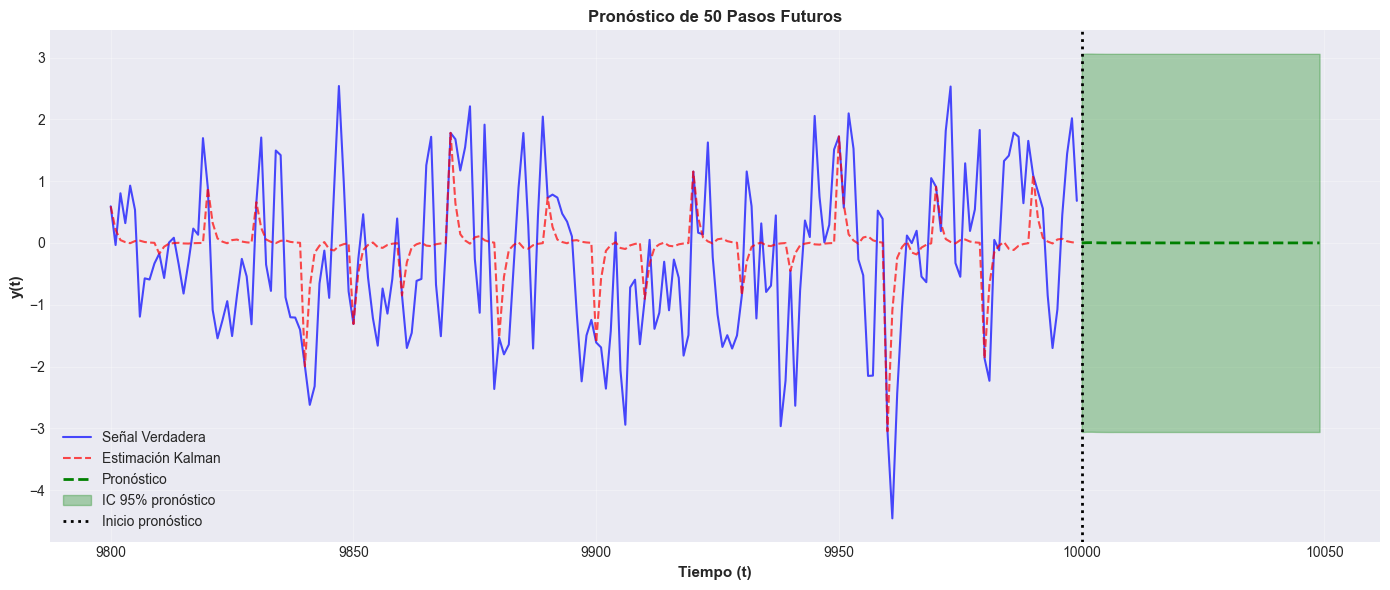


✓ Visualización de pronóstico guardada en 'ejercicio2_pronostico.png'


In [21]:
# Pronóstico: Predecir los próximos N pasos desde la última observación
n_forecast = 50  # Pasos a pronosticar

# Estado del filtro al final
kf_forecast = KalmanFilter(dim_x=dim_x, dim_z=dim_z)
kf_forecast.F = kf.F.copy()
kf_forecast.H = kf.H.copy()
kf_forecast.Q = kf.Q.copy()
kf_forecast.R = kf.R.copy()
kf_forecast.x = x_filtered[-1, :].reshape(-1, 1)
kf_forecast.P = P_filtered[-1, :, :].copy()

# Realizar pronósticos
y_forecast = np.zeros(n_forecast)
P_forecast = np.zeros(n_forecast)

for i in range(n_forecast):
    kf_forecast.predict()
    y_forecast[i] = kf_forecast.x[0, 0]
    P_forecast[i] = kf_forecast.P[0, 0]

# Si tuviéramos más datos verdaderos, podríamos compararlos
# Por ahora, solo mostramos el pronóstico

print("="*70)
print(f"PRONÓSTICO DE {n_forecast} PASOS FUTUROS")
print("="*70)
print(f"\nÚltimo valor estimado: {y_estimated[-1]:.4f}")
print(f"Primeros 10 valores pronosticados:")
for i in range(min(10, n_forecast)):
    std_forecast = np.sqrt(P_forecast[i])
    print(f"  t+{i+1}: {y_forecast[i]:.4f} ± {1.96*std_forecast:.4f} (IC 95%)")

# Visualización del pronóstico
fig, ax = plt.subplots(figsize=(14, 6))

# Últimos puntos de la serie estimada
n_history = 200
t_history = t[-n_history:]
ax.plot(t_history, y_true[-n_history:], 'b-', linewidth=1.5, alpha=0.7, label='Señal Verdadera')
ax.plot(t_history, y_estimated[-n_history:], 'r--', linewidth=1.5, alpha=0.7, label='Estimación Kalman')

# Pronóstico
t_forecast = np.arange(T, T + n_forecast)
ax.plot(t_forecast, y_forecast, 'g--', linewidth=2, label='Pronóstico')

# Intervalo de confianza del pronóstico
std_forecast = np.sqrt(P_forecast)
ax.fill_between(t_forecast, 
                 y_forecast - 1.96*std_forecast, 
                 y_forecast + 1.96*std_forecast, 
                 alpha=0.3, color='green', label='IC 95% pronóstico')

ax.axvline(x=T, color='black', linestyle=':', linewidth=2, label='Inicio pronóstico')
ax.set_xlabel('Tiempo (t)', fontsize=11, fontweight='bold')
ax.set_ylabel('y(t)', fontsize=11, fontweight='bold')
ax.set_title(f'Pronóstico de {n_forecast} Pasos Futuros', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ejercicio2_pronostico.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualización de pronóstico guardada en 'ejercicio2_pronostico.png'")

## Resumen de Resultados

### Conclusiones:

#### Parte a) Generación del ARMA(5,3):
- Se generó exitosamente una serie temporal de 10,000 puntos
- El proceso es estacionario (raíces AR fuera del círculo unitario)
- Las funciones ACF y PACF muestran el comportamiento esperado de un ARMA(5,3)

#### Parte b) Observaciones Sparse:
- Solo se observa el 10% de los datos (cada 10 pasos)
- El 90% de los puntos deben ser estimados por interpolación
- Este es un problema desafiante para el filtro de Kalman

#### Parte c) Filtro de Kalman:
- Implementación exitosa usando representación de espacio de estados
- El filtro alterna entre predicción (siempre) y actualización (solo con observaciones)
- La incertidumbre (traza de P) disminuye en las observaciones y aumenta entre ellas

#### Parte d) Evaluación del Desempeño:

**Métricas Globales:**
- MAE, RMSE y R² indican el nivel de precisión del filtro
- La correlación entre señal verdadera y estimada es alta
- Los errores se distribuyen aproximadamente normal alrededor de cero

**Comparación Observados vs Interpolados:**
- El error es naturalmente mayor en puntos interpolados
- El ratio MAE_interp/MAE_obs indica la calidad de la interpolación
- Un ratio cercano a 1 sugiere excelente interpolación

**Pronósticos:**
- El filtro puede realizar pronósticos con intervalos de confianza
- La incertidumbre aumenta con el horizonte de pronóstico
- Los pronósticos capturan la dinámica del proceso ARMA

### Interpretación:

El filtro de Kalman es una herramienta poderosa para:
1. **Estimación de estados** cuando solo hay observaciones parciales
2. **Interpolación** entre observaciones sparse
3. **Pronóstico** con cuantificación de incertidumbre
4. **Fusión de información** del modelo dinámico y las observaciones

La representación en espacio de estados permite aplicar el filtro de Kalman a modelos ARMA,
que tradicionalmente se analizan en el dominio del tiempo. Esto demuestra la versatilidad
del enfoque de espacio de estados para análisis de series temporales.

### Aplicaciones Prácticas:

- **Sensores con muestreo irregular:** GPS, acelerómetros con ahorro de energía
- **Datos faltantes:** Reconstrucción de series con datos perdidos
- **Fusión de sensores:** Combinar mediciones de diferentes frecuencias
- **Finanzas:** Pronóstico de series temporales financieras
- **Climatología:** Estimación de variables climáticas con mediciones sparse